In [51]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install keras

In [3]:
!pip install tensorflow


In [4]:
import pandas as pd
import numpy as np
import nltk
import string
nltk.download('punkt_tab')
# text preprocessing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
import re, sys, os, csv

from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM,GRU, Dense

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Defining vector space dimension and fixed input size

In [5]:
# Number of labels: joy, anger, fear, sadness, neutral
num_classes = 6

# Number of dimensions for word embedding
embed_num_dims = 100

# Max input length (max number of words)
max_seq_len = 200

class_names = ['sadness','joy', 'love', 'anger', 'fear','surprise']

Importing our training and testing datasets

In [6]:
data_train = pd.read_csv('/content/drive/MyDrive/project/train_data2.csv', encoding='utf-8')
data_test = pd.read_csv('/content/drive/MyDrive/project/test_data2.csv', encoding='utf-8')




In [7]:
# Assuming 'class_names' is a dictionary mapping integer labels to emotion strings
class_names = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear',5:'surprise'}

# Convert integer labels to emotion strings
data_test['label'] = data_test['label'].map(class_names)
data_train['label'] = data_train['label'].map(class_names)

In [8]:
data = pd.concat([data_train, data_test], ignore_index=True)

In [9]:
X_train = data_train.text
X_test = data_test.text
y_train = data_train.label
y_test = data_test.label


In [10]:
d = pd.concat([X_train, X_test], ignore_index=True)

In [11]:
tokenized_sentences = [sentence.split(" ") for sentence in d]
longest_sen = max(tokenized_sentences, key=len)
longest_sen_length = len(longest_sen)
shortest_sen = min(tokenized_sentences, key=len)
shortest_sen_length = len(shortest_sen)

print("Longest sentence:", longest_sen)
print("Length of longest sentence:", longest_sen_length)
print("Shortest sentence:", shortest_sen)
print("Length of shortest sentence:", shortest_sen_length)

Longest sentence: ['a', 'few', 'days', 'back', 'i', 'was', 'waiting', 'for', 'the', 'bus', 'at', 'the', 'bus', 'stop', 'before', 'getting', 'into', 'the', 'bus', 'i', 'had', 'prepared', 'the', 'exact', 'amount', 'of', 'coins', 'to', 'pay', 'for', 'the', 'bus', 'fair', 'and', 'when', 'i', 'got', 'into', 'the', 'bus', 'i', 'put', 'these', 'coins', 'into', 'the', 'box', 'meant', 'to', 'collect', 'the', 'bus', 'fair', 'i', 'thought', 'that', 'i', 'had', 'paid', 'and', 'wanted', 'to', 'get', 'inside', 'however', 'the', 'bus', 'driver', 'called', 'me', 'and', 'asked', 'me', 'in', 'an', 'impolite', 'way', 'if', 'the', 'coins', 'were', 'stuck', 'at', 'the', 'opening', 'of', 'the', 'box', 'he', 'had', 'not', 'seen', 'me', 'paying', 'and', 'there', 'wasnt', 'a', 'stack', 'of', 'coins', 'in', 'the', 'box', 'i', 'could', 'not', 'understand', 'this', 'and', 'the', 'driver', 'kept', 'questioning', 'me', 'he', 'made', 'me', 'feel', 'angry', 'and', 'at', 'last', 'i', 'inserted', 'a', 'dollar', 'coin',

In [12]:
print(data.label.value_counts())
data.head(100)

label
joy         141067
sadness     121187
anger        57317
fear         47712
love         34554
surprise     14972
Name: count, dtype: int64


,text,label
0,im sharing what weve done and learned only bec...,fear
1,i sit quietly trying to get other work done bu...,sadness
2,i feel very jolly,joy
3,i like to keep it on my desk for a middle of t...,anger
4,i feel the witness is sincere,joy
...,...,...
95,i awake i want to feel this and be assured i a...,joy
96,i feel bad for having kept things from her in ...,sadness
97,i feel impatient with the writing process itse...,anger
98,i feel relieved when i am put down,joy


data cleaning

In [13]:
def clean_text(data):

    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    data = re.sub(r'[^\w\s]','', data)
    data = re.sub(r'\d','',data)

    # tokenization using nltk
    data = data.lower()
    data = word_tokenize(data)
    stop_words = set(stopwords.words('english'))
    data = [word for word in data if word not in stop_words]

    return data

In [14]:
texts = [' '.join(clean_text(text)) for text in data.text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

In [15]:
print(texts_train[4])

feel witness sincere


In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 75145


In [17]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[    0,     0,     0, ...,   458,    13,   419],
       [    0,     0,     0, ...,     2,  3180,   357],
       [    0,     0,     0, ...,     0,     1,  1070],
       ...,
       [    0,     0,     0, ...,     7,  2029,  1278],
       [    0,     0,     0, ..., 68153,    92,    42],
       [    0,     0,     0, ...,     1,   487,    10]], dtype=int32)

In [18]:
encoding = {
    'sadness':0,
    'joy':1,
    'love':2,
    'anger':3,
    'fear':4,
    'surprise':5
}

# Integer labels
y_train = [encoding[x] for x in data_train.label]
y_test = [encoding[x] for x in data_test.label]

In [19]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.]])

3. Import pretrained word vectors

In [20]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [21]:
def create_embedding_matrix1(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(values[1:], dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [22]:
embedd_matrix = create_embedding_matrix('/content/drive/MyDrive/project/glove.twitter.27B.100d.txt', index_of_words, embed_num_dims)
embedd_matrix.shape

(75146, 100)

In [23]:

# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 55884
New words found: 19261


In [24]:
# Embedding layer before the actaul LSTM
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


4. Create LSTM Pipeline

In [25]:
# Convolution
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense,Dropout,Flatten
# Parameters
from keras.optimizers import SGD,Adam
from keras import regularizers
lstm_output_size = 128
bidirectional = True

# Embedding Layer, LSTM or biLSTM, Dense, softmax
model = Sequential()
model.add(embedd_layer)

model.add(Conv1D(200, kernel_size=3, activation = "relu"))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Flatten())
    #l2 regularizer
model.add(Dense(100,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
model.add(Dense(6, activation='softmax'))
    #sgd= SGD(lr=0.0001,decay=1e-6,momentum=0.9,nesterov=True)
adam=Adam(learning_rate=0.0005,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     7,514,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,514,600 (28.67 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,514,600 (28.67 MB)

5. Train the Model

In [26]:
batch_size = 256
epochs = 5

hist = model.fit(X_train_pad, y_train,
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/5
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 110s 78ms/step - accuracy: 0.6302 - loss: 1.2114 - val_accuracy: 0.9092 - val_loss: 0.2485
Epoch 2/5
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 138s 78ms/step - accuracy: 0.9180 - loss: 0.2104 - val_accuracy: 0.9286 - val_loss: 0.1475
Epoch 3/5
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 143s 79ms/step - accuracy: 0.9315 - loss: 0.1406 - val_accuracy: 0.9311 - val_loss: 0.1346
Epoch 4/5
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 142s 79ms/step - accuracy: 0.9357 - loss: 0.1184 - val_accuracy: 0.9356 - val_loss: 0.1148
Epoch 5/5
1303/1303 ━━━━━━━━━━━━━━━━━━━━ 139s 77ms/step - accuracy: 0.9387 - loss: 0.1074 - val_accuracy: 0.9359 - val_loss: 0.1207


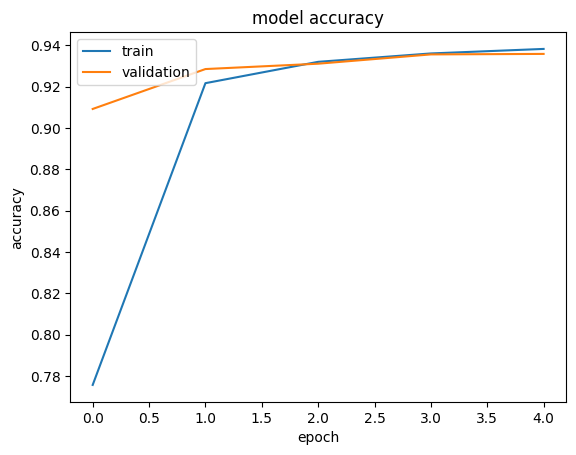

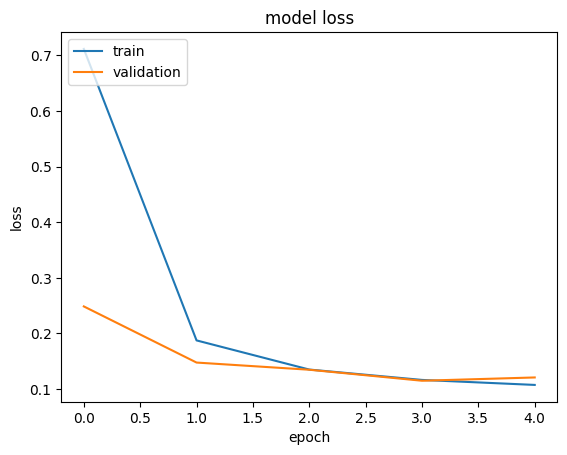

In [27]:
#  "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

6. Evaluation

In [28]:
# creates a HDF5 file 'my_model.h5'
model.save('models/CNN_biLSTM_dataset2.h5')

In [33]:
from keras.models import load_model
predictor = load_model('models/CNN_biLSTM_dataset2.h5')

In [34]:
predictions = predictor.predict(X_test_pad)


2606/2606 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step


In [43]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
true_labels = le.fit_transform(data_test.label)  # Converts string labels to integers
print(classification_report(true_labels, predicted_labels))


              precision    recall  f1-score   support

           0       0.02      0.05      0.03     11339
           1       0.00      0.00      0.00      9376
           2       0.01      0.00      0.00     28247
           3       0.00      0.00      0.00      6853
           4       0.06      0.02      0.03     24504
           5       0.74      0.96      0.84      3043

    accuracy                           0.05     83362
   macro avg       0.14      0.17      0.15     83362
weighted avg       0.05      0.05      0.05     83362



In [45]:
import numpy as np
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# STEP 1: Convert predictions (if they are probabilities or one-hot) to class indices
predicted_labels = np.argmax(predictions, axis=1)

# STEP 2: Convert string labels in data_test.label to integers
le = LabelEncoder()
true_labels = le.fit_transform(data_test.label)

# STEP 3: Generate the classification report with readable class names
print(classification_report(true_labels, predicted_labels, target_names=le.classes_))


              precision    recall  f1-score   support

       anger       0.02      0.05      0.03     11339
        fear       0.00      0.00      0.00      9376
         joy       0.01      0.00      0.00     28247
        love       0.00      0.00      0.00      6853
     sadness       0.06      0.02      0.03     24504
    surprise       0.74      0.96      0.84      3043

    accuracy                           0.05     83362
   macro avg       0.14      0.17      0.15     83362
weighted avg       0.05      0.05      0.05     83362



In [47]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Encode true labels if they're strings
le = LabelEncoder()
true_labels = le.fit_transform(data_test.label)

# Accuracy
print("Accuracy: {:.2f}%".format(accuracy_score(true_labels, predicted_labels) * 100))

# F1 Score (Micro)
print("\nF1 Score: {:.2f}".format(f1_score(true_labels, predicted_labels, average='micro')))


Accuracy: 4.94%

F1 Score: 0.05


In [48]:
#plotting confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()

    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Accuracy: 4.94%
F1 Score (micro): 4.94


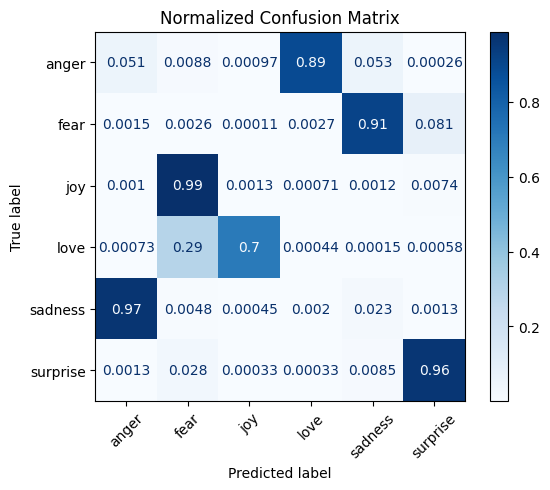

In [50]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder

# STEP 1: Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# STEP 2: Encode true labels if they're strings
le = LabelEncoder()
true_labels = le.fit_transform(data_test.label)

# STEP 3: Accuracy and F1 score
print("Accuracy: {:.2f}%".format(accuracy_score(true_labels, predicted_labels) * 100))
print("F1 Score (micro): {:.2f}".format(f1_score(true_labels, predicted_labels, average='micro') * 100))

# STEP 4: Confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_labels, predicted_labels, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Normalized Confusion Matrix')
plt.show()


Try other input

In [39]:
import time

message = ['When I meet you first time it was wonderful']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = predictor.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Message: ['When I meet you first time it was wonderful']
predicted: joy (0.19 seconds)
